In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
import os
from keras.callbacks import TensorBoard
import time
import tensorflow as tf

Using TensorFlow backend.
/home/sagnik106/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sagnik106/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sagnik106/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sagnik106/.local/lib/python3.6/site-packages/tenso

In [2]:
batch_size = 32
num_classes = 10
total_epochs=100
freeze_split=80
num_predictions = 20

In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
def conv_block(inputs):
    x=Conv2D(32, (3, 3), padding='same')(inputs)
    x=Activation('relu')(x)
    x=Conv2D(32, (3, 3))(x)
    x=Activation('relu')(x)
    x=MaxPooling2D(pool_size=(2, 2))(x)
    x=Dropout(0.25)(x)

    x=Conv2D(64, (3, 3), padding='same')(x)
    x=Activation('relu')(x)
    x=Conv2D(64, (3, 3))(x)
    x=Activation('relu')(x)
    x=MaxPooling2D(pool_size=(2, 2))(x)
    x=Dropout(0.25)(x)
    conv=Model(inputs, x)
    return conv

In [6]:
def nn_block(inputs):
    x=Flatten()(inputs)
    x=Dense(512)(x)
    x=Activation('relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(num_classes)(x)
    x=Activation('softmax')(x)
    nn=Model(inputs,x)
    return nn

In [7]:
def model_maker():
    a=x_train.shape[1]
    b=x_train.shape[2]
    a=((a-2)//2)-2
    b=((b-2)//2)-2
    nshape=(a//2,b//2,64)
    inputc=Input(shape=x_train.shape[1:])
    inputn=Input(shape=nshape)
    con=conv_block(inputc)
    nn=nn_block(inputn)
    model=Model(inputc,nn(con(inputc)))
    con.trainable=False
    frozen_model=Model(inputc,nn(con(inputc)))
    print(con.summary())
    print(nn.summary())
    print(model.summary())
    print(frozen_model.summary())
    return model, frozen_model

In [8]:
model,f_model=model_maker()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0  

In [9]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.name="Unfrozen Weights"
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
f_model.name="Frozen Weights"
f_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [10]:
tensorboard = TensorBoard(log_dir = "logs/{}".format(time.time()))
tensorboard.set_model(model)
tensorboard.set_model(f_model)

In [11]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [12]:
with tf.device('/gpu:0'):
    print("Unfrozen Model")
    history_model=model.fit(x_train, y_train, batch_size=batch_size, epochs=(freeze_split*total_epochs)//100, verbose=1, validation_data=(x_test, y_test), shuffle=True, callbacks=[tensorboard])
    print("\n\nFrozen Model")
    history_model_f=f_model.fit(x_train, y_train, batch_size=batch_size, epochs=((100-freeze_split)*total_epochs)//100, verbose=1, validation_data=(x_test, y_test), shuffle=True, callbacks=[tensorboard])

Unfrozen Model

Train on 50000 samples, validate on 10000 samples
Epoch 1/80
50000/50000 [==============================] - 30s 605us/step - loss: 2.1564 - accuracy: 0.2084 - val_loss: 2.1317 - val_accuracy: 0.2082

Epoch 2/80
50000/50000 [==============================] - 30s 606us/step - loss: 2.0041 - accuracy: 0.2769 - val_loss: 2.1227 - val_accuracy: 0.2169
Epoch 3/80
50000/50000 [==============================] - 31s 626us/step - loss: 1.9408 - accuracy: 0.3031 - val_loss: 2.1274 - val_accuracy: 0.2288
Epoch 4/80
50000/50000 [==============================] - 33s 651us/step - loss: 1.8995 - accuracy: 0.3219 - val_loss: 2.1251 - val_accuracy: 0.2313
Epoch 5/80
50000/50000 [==============================] - 33s 658us/step - loss: 1.8685 - accuracy: 0.3324 - val_loss: 2.0804 - val_accuracy: 0.2456
Epoch 6/80
50000/50000 [==============================] - 33s 665us/step - loss: 1.8437 - accuracy: 0.3389 - val_loss: 2.0600 - val_accuracy: 0.2574
Epoch 7/80
50000/50000 [===============

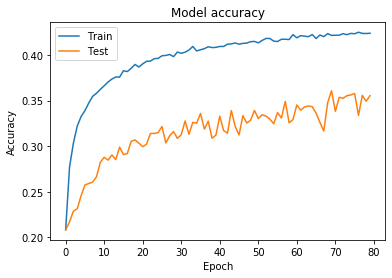

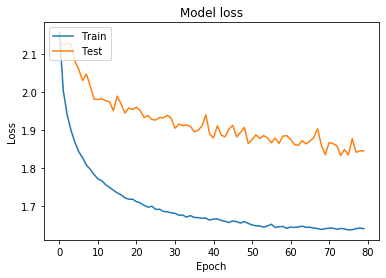

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

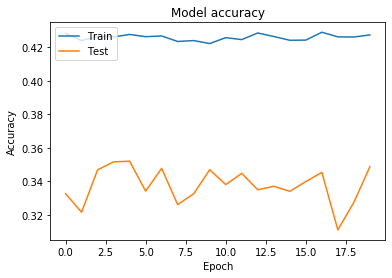

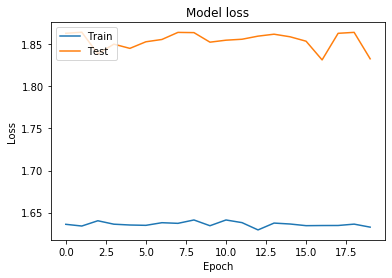

In [21]:
# Plot training & validation accuracy values
plt.plot(history_model_f.history['accuracy'])
plt.plot(history_model_f.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_model_f.history['loss'])
plt.plot(history_model_f.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()